In [121]:
import matplotlib.pyplot as plt
import numpy as np
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import init
import torchvision
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
from torch.autograd import Variable
from torch.nn import functional as F
from torchvision import datasets, transforms
import cv2

In [122]:
n_epochs=20
batch_size=128

In [123]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [124]:
transform= transforms.ToTensor()
traindataset=datasets.CIFAR10('./data',transform=transform,download=True, train=True)
data_loader = DataLoader(traindataset, batch_size=128, shuffle=True, drop_last=True, num_workers=2)
testdataset=datasets.CIFAR10('./data',transform=torchvision.transforms.ToTensor(),download=True, train=False)
test_data_loader=DataLoader(testdataset, batch_size=batch_size,shuffle=True, drop_last=True, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [125]:
class Q_net(nn.Module):
    def __init__(self,X_dim,N,z_dim):
        super(Q_net, self).__init__()
        self.encoder= nn.Sequential(
        nn.Conv2d(3,16,kernel_size=4,stride=2,padding=1),
        nn.BatchNorm2d(16),
        nn.ReLU(),
        nn.Conv2d(16,32,kernel_size=4,stride=2,padding=1),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.Conv2d(32,64,kernel_size=4,stride=2,padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        )
    def forward(self, x):
        return  self.encoder(x)

In [126]:
# Decoder
class P_net(nn.Module):
    def __init__(self,X_dim,N,z_dim):
        super(P_net, self).__init__()
        self.decoder=nn.Sequential(
        nn.ConvTranspose2d(64,32,kernel_size=4,stride=2,padding=1),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.ConvTranspose2d(32,16,kernel_size=4,stride=2,padding=1),
        nn.BatchNorm2d(16),
        nn.ReLU(),
        nn.ConvTranspose2d(16,3,kernel_size=4,stride=2,padding=1),
        nn.BatchNorm2d(3),
        nn.Sigmoid())
    def forward(self, x):
        return self.decoder(x)

In [127]:
from torchsummary import summary
z_red_dims = 120
Q = Q_net(3*32*32,1000,z_red_dims)
Q.to(device)
P = P_net(64*4*4,1000,z_red_dims)
P.to(device)
summary(Q,(3,32,32))
summary(P,(64,4,4))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 16, 16]             784
       BatchNorm2d-2           [-1, 16, 16, 16]              32
              ReLU-3           [-1, 16, 16, 16]               0
            Conv2d-4             [-1, 32, 8, 8]           8,224
       BatchNorm2d-5             [-1, 32, 8, 8]              64
              ReLU-6             [-1, 32, 8, 8]               0
            Conv2d-7             [-1, 64, 4, 4]          32,832
       BatchNorm2d-8             [-1, 64, 4, 4]             128
              ReLU-9             [-1, 64, 4, 4]               0
Total params: 42,064
Trainable params: 42,064
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.16
Params size (MB): 0.16
Estimated Total Size (MB): 0.34
---------------------------------------------

In [128]:
class D_net_gauss(nn.Module):
    def __init__(self,N):
        super(D_net_gauss, self).__init__()
        self.disc=nn.Sequential(
        nn.ConvTranspose2d(64,32,kernel_size=4,stride=2,padding=1),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.ConvTranspose2d(32,16,kernel_size=4,stride=2,padding=1),
        nn.BatchNorm2d(16),
        nn.ReLU(),
        nn.ConvTranspose2d(16,3,kernel_size=4,stride=2,padding=1),
        nn.BatchNorm2d(3),
        nn.Sigmoid())
    def forward(self, x):
        return self.disc(x)
        

In [129]:
EPS = 1e-15
z_red_dims = 1024
Q = Q_net(32*32*3,1000,z_red_dims)
Q.to(device)
P = P_net(32*32*3,1000,z_red_dims)
P.to(device)
D_gauss = D_net_gauss(500)
D_gauss.to(device)
# Set learning rates
gen_lr = 0.0001
reg_lr = 0.00005
# Set optimizators
#encode/decode optimizers
optim_P = torch.optim.Adam(P.parameters(), lr=gen_lr)
optim_Q_enc = torch.optim.Adam(Q.parameters(), lr=gen_lr)
#regularizing optimizers
optim_Q_gen = torch.optim.Adam(Q.parameters(), lr=reg_lr)
optim_D = torch.optim.Adam(D_gauss.parameters(), lr=reg_lr)

In [130]:
def mask_function(image):
  height,width,channels= image.shape
  num_patches = int((height * width * 0.5) / 4)
  mask = np.zeros((height, width), dtype=np.uint8)
  for i in range(num_patches):
      x = np.random.randint(0, width - 2)
      y = np.random.randint(0, height - 2)
      mask[y:y+2, x:x+2] = 1
  masked_image = image * mask[:, :, np.newaxis]
  return masked_image

In [ ]:
data_iter = iter(data_loader)
iter_per_epoch = len(data_loader)
total_step = 3000
trainloss=[]
# Start training
for step in range(total_step):

    # Reset the data_iter
    if (step+1) % iter_per_epoch == 0:
        data_iter = iter(data_loader)

    # Fetch the images and labels and convert them to variables
    images, labels = next(data_iter)
    imagesnew=torch.clone(images)
    for i in range (len(images)):
      img=np.transpose(images[i],(1,2,0))
      img= mask_function(img)
      img=np.transpose(img,(2,0,1))
      images[i]=img

    images, labels = (images.view(images.size(0), -1)), (labels)
    #reconstruction loss
    P.zero_grad()
    Q.zero_grad()
    D_gauss.zero_grad()
    images=images.reshape(128,3,32,32)
    z_sample = Q(images.to(device))   #encode to z
    X_sample = P(z_sample.to(device)) #decode to X reconstruction
    recon_loss = F.binary_cross_entropy((X_sample+EPS).to(device),(imagesnew+EPS).to(device))

    recon_loss.backward()
    optim_P.step()
    optim_Q_enc.step()

    # Discriminator
    ## true prior is random normal (randn)
    ## this is constraining the Z-projection to be normal!
    Q.eval()
    z_real_gauss = Variable(torch.randn(images.size()[0], 64*4*4) * 5.).reshape(128,64,4,4)
    D_real_gauss = D_gauss(z_real_gauss.to(device))

    z_fake_gauss = Q(images.to(device))
    D_fake_gauss = D_gauss(z_fake_gauss)

    D_loss = -torch.mean(torch.log(D_real_gauss + EPS) + torch.log(1 - D_fake_gauss + EPS))

    D_loss.backward()
    optim_D.step()

    # Generator
    Q.train()
    z_fake_gauss = Q(images.to(device))
    D_fake_gauss = D_gauss(z_fake_gauss)
    
    G_loss = -torch.mean(torch.log(D_fake_gauss + EPS).to(device))

    G_loss.backward()
    optim_Q_gen.step()  
    print('Epoch',step)
    print('G loss',G_loss.item()) 
    trainloss.append(G_loss.item())



Epoch 0
G loss 0.6973319053649902
Epoch 1
G loss 0.698032796382904
Epoch 2
G loss 0.6971999406814575
Epoch 3
G loss 0.6980409622192383
Epoch 4
G loss 0.6982485055923462
Epoch 5
G loss 0.6988793611526489
Epoch 6
G loss 0.6986910700798035
Epoch 7
G loss 0.699059009552002
Epoch 8
G loss 0.698735237121582
Epoch 9
G loss 0.6985921263694763
Epoch 10
G loss 0.6985471248626709
Epoch 11
G loss 0.6985117197036743
Epoch 12
G loss 0.6978693008422852
Epoch 13
G loss 0.6987141370773315
Epoch 14
G loss 0.6988663673400879
Epoch 15
G loss 0.6972748637199402
Epoch 16
G loss 0.6977618932723999
Epoch 17
G loss 0.6990988254547119
Epoch 18
G loss 0.6979051828384399
Epoch 19
G loss 0.6980446577072144
Epoch 20
G loss 0.6984845399856567
Epoch 21
G loss 0.6988784074783325
Epoch 22
G loss 0.697727382183075
Epoch 23
G loss 0.6985869407653809
Epoch 24
G loss 0.6982735991477966
Epoch 25
G loss 0.6981579065322876
Epoch 26
G loss 0.6982555389404297
Epoch 27
G loss 0.6978073120117188
Epoch 28
G loss 0.6988821029663086

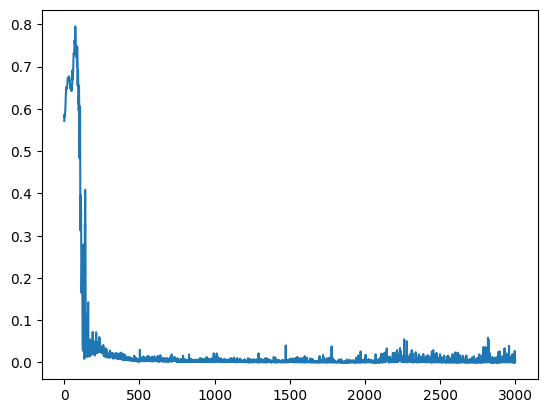

In [ ]:
z_sample = Q(imagesnew[0].to(device))   #encode to z
X_sample = P(z_sample.to(device)) #decode to X reconstruction
plt.plot(trainloss)
plt.show()

In [ ]:
X_sample=X_sample.cpu().reshape(3,32,32)

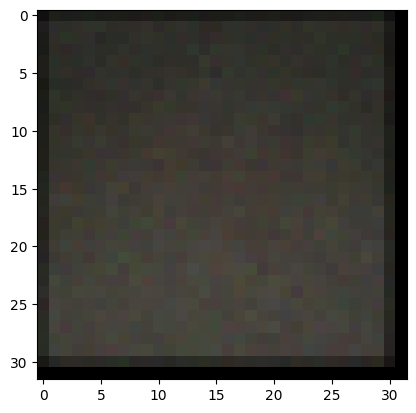

In [ ]:
plt.imshow(np.transpose(X_sample.detach().numpy(),(1,2,0)))
plt.show()


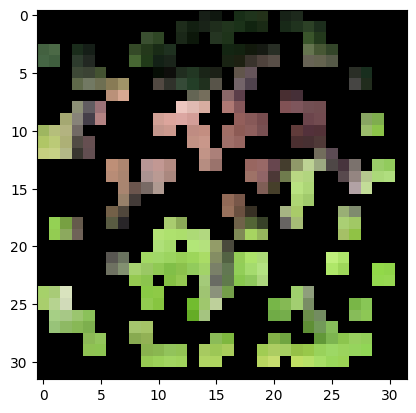

In [ ]:
image=images[0].reshape((3,32,32))
plt.imshow(np.transpose(image.detach().numpy(),(1,2,0)))
plt.show()